In [1]:
# developed in Python 3
!python --version

Python 3.12.4


# Options

In [2]:
# country ISO A2 code
COUNTRY = 'FR'

In [3]:
# optional cache for functions
CACHE_ENABLED = True

# Initialization

In [4]:
# these modules are used in 
# geo-web-method geo-web-demo geo-web-results
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

In [5]:
import json,copy,random,operator,sys,os,re

import numpy as np
import pandas as pd
import shapely as sh
import humanize as hm
import geopandas as gpd
import matplotlib.pyplot as plt

import geonamescache as gn
gn_cache = gn.GeonamesCache()

import folium
from IPython.display import HTML

import requests
from bs4 import BeautifulSoup

from requests_ratelimiter import LimiterSession
session = LimiterSession(per_second=1)
session.headers.update({'User-Agent': 'geo-web','email':'utko@vut.cz'})

from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

from joblib import Memory
memory = Memory(location=f'__CACHE/{COUNTRY}' if CACHE_ENABLED else None,verbose=0)

# Functions

In [6]:
def parse_url(url):
    '''
    Parses domain, root domain, and endpath from URL
    
    Verifies URL to be valid

    :param str url: url to parse
    :return: domain, path, root domain
    :rtype: dict
    '''
    
    # remove protocol
    url = url.removeprefix('https://')
    url = url.removeprefix('http://')

    domain = pd.NA; path = pd.NA; root = pd.NA

    # domain and path
    parsed = url.split('/',1)     
    domain = parsed[0]

    # allowed chars alpha, numbers and .-
    if ('.' not in domain or 
        not domain.replace('.','').replace('-','').isalnum()): 
        
        domain = pd.NA
        
    if pd.notna(domain) and len(parsed) == 2:  
        path = parsed[1]
        if path == '': path = pd.NA

    # other domain levels
    if pd.notna(domain):
        parsed = domain.rsplit('.',2)[-2:]
        root = '.'.join(parsed)

    return {'domain':domain,'path':path,'root':root}
    
assert parse_url(url= 'https://www.overleaf.com/user/subscription/plans') == {
    'domain': 'www.overleaf.com', 'path': 'user/subscription/plans',
    'root': 'overleaf.com'}

parse_url(url= 'https://www.overleaf.com/user/subscription/plans')

{'domain': 'www.overleaf.com',
 'path': 'user/subscription/plans',
 'root': 'overleaf.com'}

In [7]:
def frame_info(frame,samples=5):

    size = len(frame)  
    
    frame_sample = frame.sample(min(samples,size))
    display(frame_sample)

    mem = frame.memory_usage(deep=True).sum()
    
    print(f'Size {size}, Memory {hm.naturalsize(mem)}')
    print(frame.dtypes)

    return

# GeoWeb description

## Load data

In [8]:
data = pd.read_parquet(f'geo-web-results/geo-web-{COUNTRY}.parquet')

# memory
data = data.astype({
    'web': pd.StringDtype('pyarrow'),
    'online': pd.StringDtype('pyarrow'),
    'lat': pd.StringDtype('pyarrow'),
    'lon': pd.StringDtype('pyarrow')
})

frame_info(data)

,web,lat,lon,city,country,online
391851,http://www.maison-souffrance-et-travail-78.fr/...,48.9304688,2.0469782,Poissy,FR,20230402024454
516960,https://ecoleboisard.com/index.php/actualites,45.7549601,4.9339600,Vaulx-en-Velin,FR,20230528224719
365297,http://www.regieparis14.org/solidarites-locale...,48.8259512,2.3081956,Paris,FR,20230326024417
30194,https://www.albert-andco.com/bureau-le-salon/,50.2854482,2.7752991,Arras,FR,20230321081326
136883,https://www.aumetscliche.com/menus/,45.1913463,5.7323032,Grenoble,FR,20230131194520


Size 542551, Memory 68.1 MB
web        string[pyarrow]
lat        string[pyarrow]
lon        string[pyarrow]
city              category
country           category
online     string[pyarrow]
dtype: object


## Basic stats

In [9]:
print(f'Country {COUNTRY}\n')

unique_locs = data.drop_duplicates(subset=['lat', 'lon'])
print(f'GeoWeb locations {len(unique_locs)}\n')

print(f'GeoWeb webpages {len(data)}\n')

print(f'GeoWeb cities {data.city.nunique()}\n')

print(f'Processing stat for GeoWeb websites')
url_parsed = data.progress_apply(lambda row: parse_url(row.web),axis = 1)
url_parsed = pd.DataFrame(url_parsed.tolist())
domains = url_parsed.domain.nunique()
paths = url_parsed.path.nunique()

print()
print(f'GeoWeb domains {domains}\n')
print(f'GeoWeb paths {paths}\n')

# top 20 cities
print('GeoWeb locations per city (top 10)')
print(f'{data.drop_duplicates(subset=['lat', 'lon']).groupby(
    'city',observed=True).web.apply(len).sort_values(ascending=False).iloc[0:10]}\n')

print(f'GeoWeb webpages per city (top 10)')
print(data.groupby('city',observed=True).web.apply(len).sort_values(ascending=False).iloc[0:10])

Country FR

GeoWeb locations 15965

GeoWeb webpages 542551

GeoWeb cities 556

Processing stat for GeoWeb websites
100%|███████████████████████████████████████████████████| 542551/542551 [00:02<00:00, 253910.67it/s]

GeoWeb domains 23424

GeoWeb paths 368656

GeoWeb locations per city (top 10)
city
Paris          2417
Lyon            881
Toulouse        671
Nice            449
Nantes          314
Rennes          307
Bordeaux        269
Strasbourg      233
Rouen           227
Montpellier     169
Name: web, dtype: int64

GeoWeb webpages per city (top 10)
city
Paris          86094
Lyon           29784
Toulouse       21643
Nice           14130
Rennes         11040
Nantes         10898
Bordeaux        9154
Rouen           7727
Strasbourg      7256
Montpellier     5551
Name: web, dtype: int64


## Data samples

In [10]:
no_samples = 5

In [11]:
print(f'Sample GeoWeb at locations')
# sample locs
data.sample(frac=1).drop_duplicates(subset='city').drop_duplicates(subset=['lat','lon']).sample(no_samples)

Sample GeoWeb at locations


,web,lat,lon,city,country,online
152368,https://www.hotel-artdecolille.com/en/pagex/ho...,50.6459694,3.0760337,La Madeleine,FR,20230322020506
388039,https://www.frigeland.fr/,42.6792917,2.8808739,Perpignan,FR,20230127010622
141402,https://www.bassinaventures.com/ouverture-du-p...,44.6215045,-1.1015335,Gujan-Mestras,FR,20230129144557
390450,https://www.auto-ecole-carasco.fr/code-en-visio/,44.8082125,-0.6491685,Pessac,FR,20230129161232
442967,https://www.lechevallier-monteil.fr/entreprise...,49.0992555,-1.0874293,Saint-Lô,FR,20240303085314


In [12]:
print(f'Sample GeoWeb in city')
# sample city
city = data.city.sample(1).values[0]
data.loc[data.city == city].sample(no_samples)

Sample GeoWeb in city


,web,lat,lon,city,country,online
397346,https://www.ateliermba.com/projets/montgenevre...,46.9030355,6.3586626,Pontarlier,FR,20231129094555
397029,https://profen.fr/Ilot+St+Pierre+-+PONTARLIER+...,46.8984025,6.3419062,Pontarlier,FR,20230328152824
398227,https://www.kdosports.fr/gift-card,46.9039843,6.3495833,Pontarlier,FR,20230930204436
398118,https://www.bejsas.com/actualite/,46.9096122,6.3410345,Pontarlier,FR,20230322063902
397102,https://www.gescorec.com/plan-du-site,46.9023648,6.3476092,Pontarlier,FR,20230606134734


In [13]:
print(f'Sample GeoWeb in cities (one per city)')
data.sample(frac=1).drop_duplicates(subset="city").sample(no_samples)

Sample GeoWeb in cities (one per city)


,web,lat,lon,city,country,online
99037,https://www.au-tout-va-bien.fr/category/menu-c...,49.7632003,4.7189967,Charleville-Mézières,FR,20230207084758
456458,https://www.garages-tanguy.com/nos-garages-meu...,48.2625996,6.9858690,Sainte-Marguerite,FR,20231129063000
39913,"https://www.minavignon.fr/service,salle-aqua--...",43.9346984,4.8364823,Avignon,FR,20240228083430
103304,https://lcnp.fr/2018/07/11/une-icone-coreenne-...,48.7758264,2.2309218,Châtenay-Malabry,FR,20230331040920
9846,https://www.michel-equipement.fr/shop/pubert-x...,44.1064350,4.0912670,Alès,FR,20230602223346


## Country map

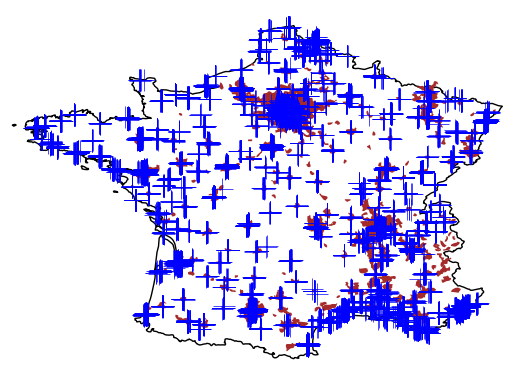

In [14]:
# country borders
world = gpd.read_file('natural-earth/ne_10m_admin_0_countries')
world = world.drop(
    columns = world.columns.difference(['ISO_A2','geometry']))

# country population
popul = gpd.read_file('natural-earth/ne_10m_urban_areas')
popul = popul.drop(
    columns = popul.columns.difference(['ISO_A2','geometry']))

# European France
world_units = gpd.read_file('natural-earth/ne_10m_admin_0_map_units')
world_units = world_units.drop(
    columns = world_units.columns.difference(['ISO_A2','geometry']))

# country map
country_map = world.loc[world.ISO_A2 == COUNTRY]

# for France use European part
if COUNTRY == 'FR': 
    country_map = world_units.loc[world_units.ISO_A2 == COUNTRY]  

# plot map
ax = country_map.plot(color='white', edgecolor='black')

# plot country main populated areas
main_pop_country = gpd.sjoin(popul, country_map, predicate='within')
# we scale just-informative popul areas for better visibility in country plots
ax = main_pop_country.scale(2,2).plot(ax = ax,color='brown')

# locs
locs_map = data.drop_duplicates(subset=['lat', 'lon']).copy()

# transform loc coordinates
locs_map['loc_crd'] = gpd.points_from_xy(locs_map.lon,locs_map.lat)

# geopandas
locs_map = gpd.GeoDataFrame(locs_map)
locs_map.loc_crd = locs_map.loc_crd.set_crs('EPSG:4326')

# plot locs
ax = locs_map.loc_crd.plot(ax = ax,
                          marker = '+', color = 'blue',
                          markersize = 250,lw = 0.5)

# trim maps for the paper
# only mainland (exclude overseas regions and islands)
if COUNTRY == 'FR':
    plt.xlim(left=-5.2,right=8.3); plt.ylim(top=51.5,bottom=42)

plt.axis('off')

plt.savefig(f'geo-web-maps/geo-web-map-{COUNTRY}.pdf',
    bbox_inches='tight',pad_inches=0)

plt.savefig(f'geo-web-maps/geo-web-map-{COUNTRY}.png',
    bbox_inches='tight',pad_inches=0)

plt.show()